In [ ]:


!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.5 MB/s eta 0:00:00


In [ ]:

!pip install deap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 7.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch_geometric.nn import GATConv
from torch_geometric.utils import dense_to_sparse
from transformers import BertModel, BertTokenizer
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
df=pd.read_csv("/content/Crop_recommendation.csv")

In [ ]:
df.isnull().sum()

,0
N,0
P,0
K,0
temperature,0
humidity,0
ph,0
rainfall,0
label,0


In [ ]:
df['label'].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

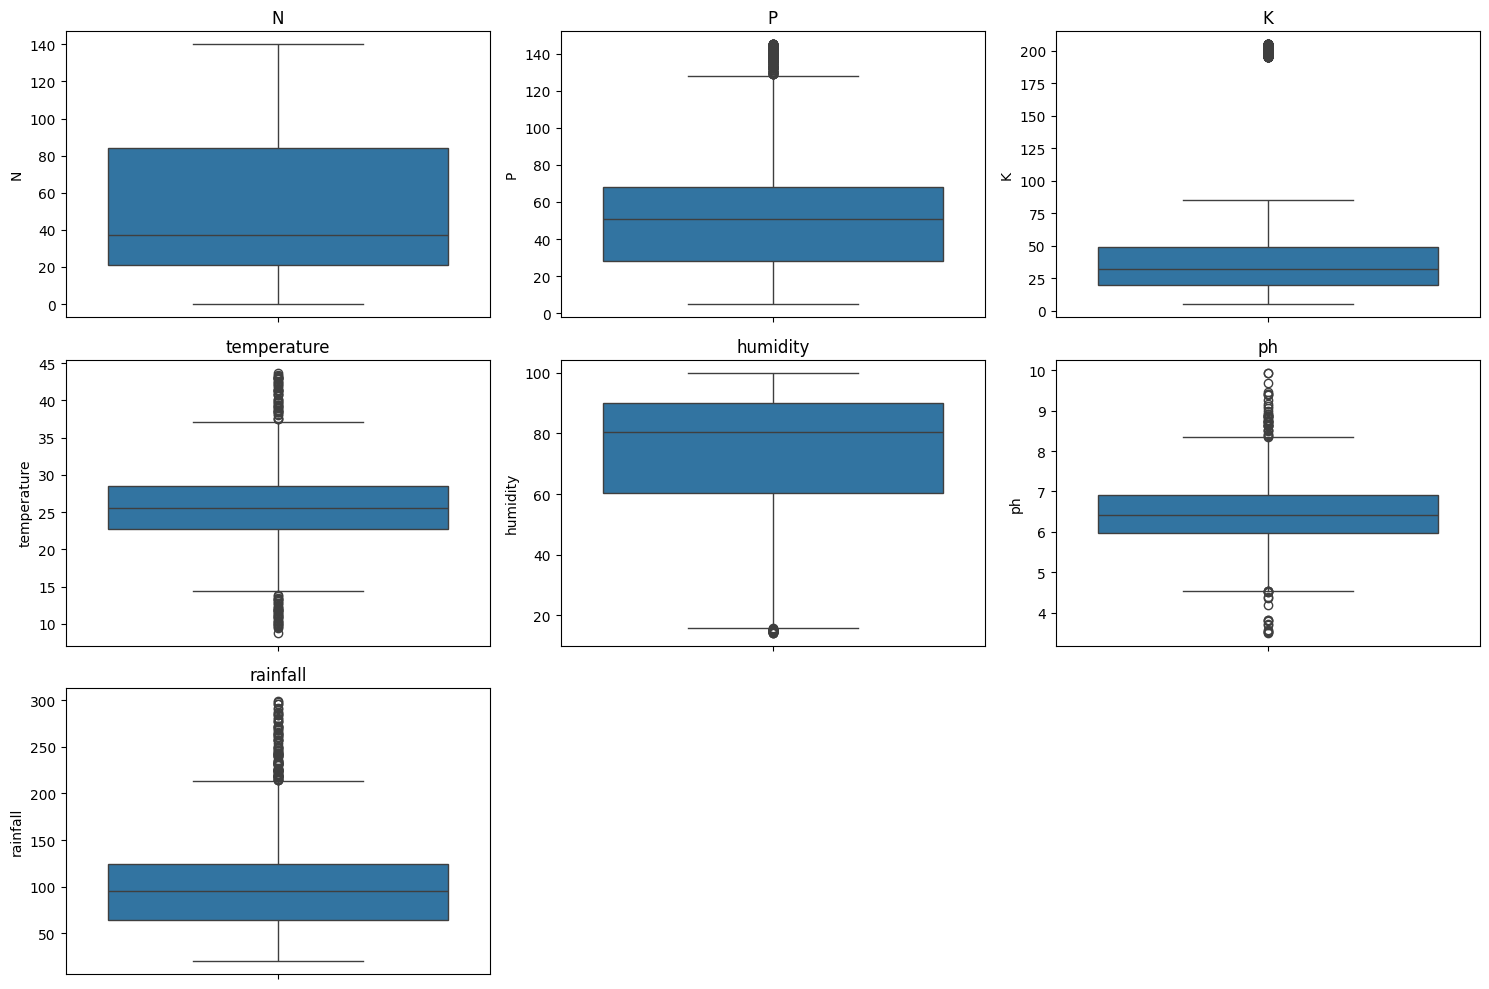

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot boxplots for numerical columns
numerical_columns = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [ ]:
num_cols = df.select_dtypes(include=['number']).columns

In [ ]:
num_cols

Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall'], dtype='object')

In [ ]:
def remove_outliers_iqr(df, columns):
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the dataset to remove outliers
    filtered_df = df[~((df[columns] < lower_bound) | (df[columns] > upper_bound)).any(axis=1)]
    return filtered_df

In [ ]:
df2 = remove_outliers_iqr(df, num_cols)

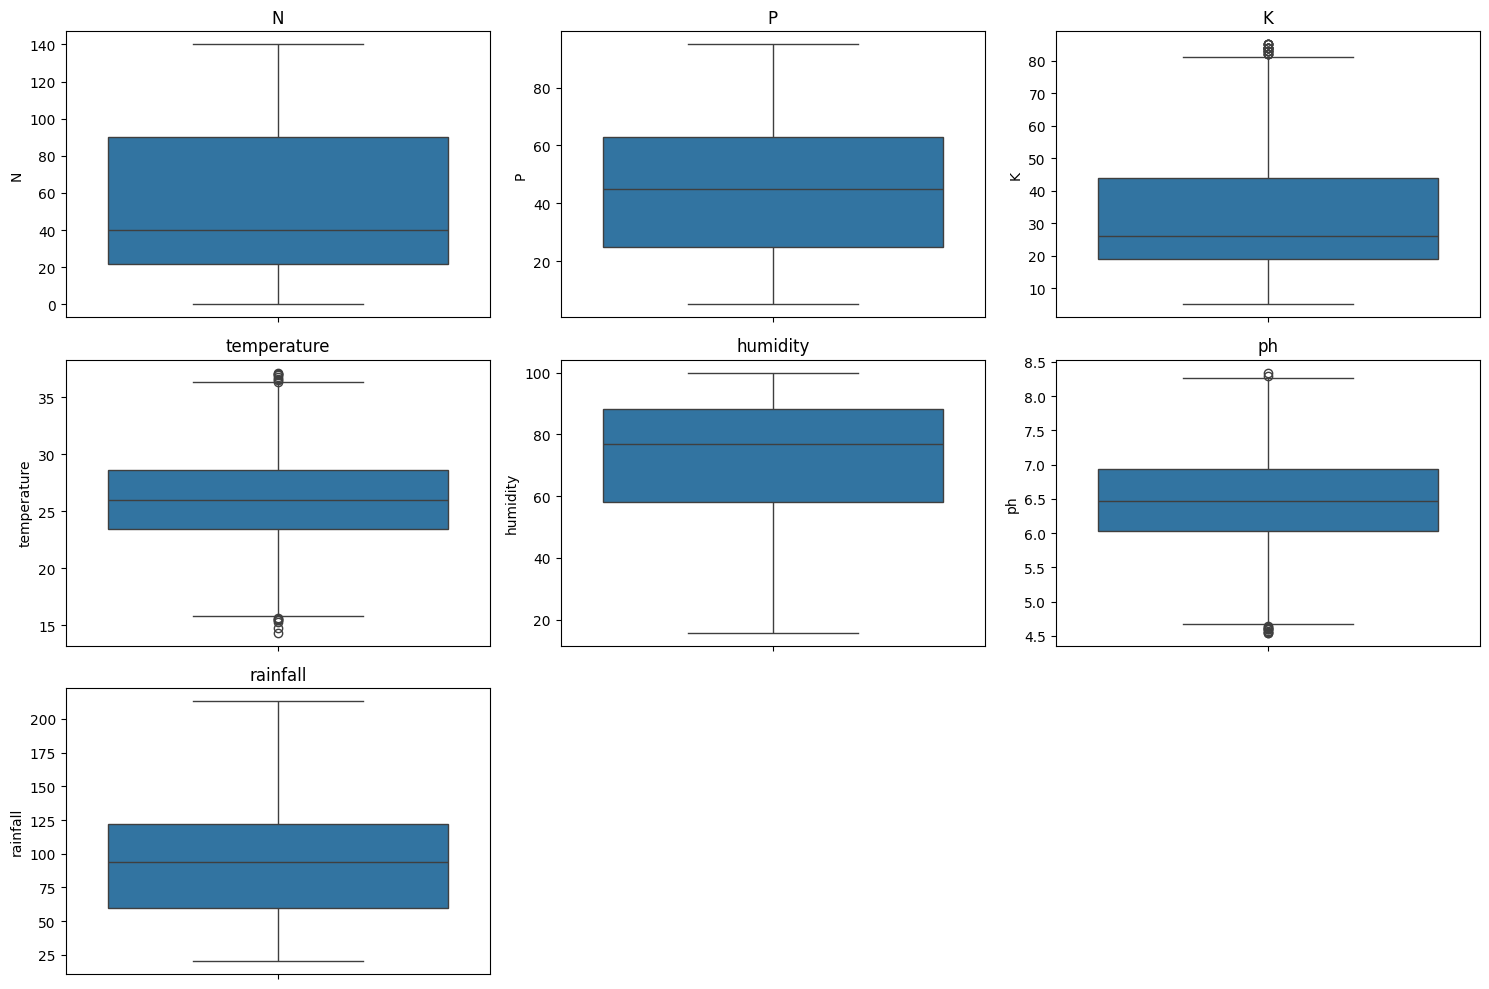

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot boxplots for numerical columns
numerical_columns = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df2[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [ ]:

from sklearn.preprocessing import LabelEncoder

In [ ]:
df.shape

(2200, 8)

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
df2['label_encode'] = label_encoder.fit_transform(df2['label'])

<ipython-input-15-f18488a1c8f6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['label_encode'] = label_encoder.fit_transform(df2['label'])


In [ ]:
df2.head(3)

,N,P,K,temperature,humidity,ph,rainfall,label,label_encode
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,18
13,93,56,36,24.014976,82.056872,6.984354,185.277339,rice,18
14,94,50,37,25.665852,80.663850,6.948020,209.586971,rice,18


In [ ]:
# prompt: for X N	P	K	temperature	humidity	ph	rainfall take this value and for y take label_encode

X = df2[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']].values
y = df2['label_encode'].values


In [ ]:

from sklearn.preprocessing import StandardScaler


In [ ]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
# Apply SMOTE **before splitting**
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [ ]:
X_resampled.shape

(2000, 7)

In [ ]:
# Split dataset


X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train).long()
y_test_tensor = torch.from_numpy(y_test).long()


In [ ]:

# Convert to PyTorch tensors
#X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
#X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
#y_train_tensor = torch.tensor(y_train, dtype=torch.long)
#y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [ ]:
# Create DataLoader
def create_dataloader(X, y, batch_size=32):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_loader = create_dataloader(X_train_tensor, y_train_tensor)
test_loader = create_dataloader(X_test_tensor, y_test_tensor)


In [ ]:
# SwiFT Model Implementation
class SwiFT(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=64, num_heads=8, num_layers=4):
        super(SwiFT, self).__init__()

        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.transformer_layers = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, batch_first=True),
            num_layers=num_layers
        )
        self.fusion_layer = nn.Linear(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # Add sequence dimension
        x = self.transformer_layers(x)
        x = self.fusion_layer(x.squeeze(1))  # Weighted fusion
        return self.classifier(x)


In [ ]:
# Initialize model
input_dim = X_train.shape[1]
num_classes = len(np.unique(y))
model = SwiFT(input_dim, num_classes)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [ ]:
def train(model, train_loader, epochs=30):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

In [ ]:
# Train and evaluate
train(model, train_loader, epochs=50)
evaluate(model, test_loader)


Epoch 1, Loss: 1.2749
Epoch 2, Loss: 0.3949
Epoch 3, Loss: 0.3120
Epoch 4, Loss: 0.1996
Epoch 5, Loss: 0.1962
Epoch 6, Loss: 0.2115
Epoch 7, Loss: 0.1703
Epoch 8, Loss: 0.2078
Epoch 9, Loss: 0.2484
Epoch 10, Loss: 0.1639
Epoch 11, Loss: 0.1789
Epoch 12, Loss: 0.1346
Epoch 13, Loss: 0.1187
Epoch 14, Loss: 0.0950
Epoch 15, Loss: 0.1485
Epoch 16, Loss: 0.1659
Epoch 17, Loss: 0.1594
Epoch 18, Loss: 0.0869
Epoch 19, Loss: 0.0909
Epoch 20, Loss: 0.0805
Epoch 21, Loss: 0.1650
Epoch 22, Loss: 0.1821
Epoch 23, Loss: 0.0922
Epoch 24, Loss: 0.0831
Epoch 25, Loss: 0.1094
Epoch 26, Loss: 0.0891
Epoch 27, Loss: 0.0537
Epoch 28, Loss: 0.0722
Epoch 29, Loss: 0.1454
Epoch 30, Loss: 0.0905
Epoch 31, Loss: 0.0544
Epoch 32, Loss: 0.0439
Epoch 33, Loss: 0.0508
Epoch 34, Loss: 0.1163
Epoch 35, Loss: 0.1161
Epoch 36, Loss: 0.0968
Epoch 37, Loss: 0.0846
Epoch 38, Loss: 0.1118
Epoch 39, Loss: 0.1061
Epoch 40, Loss: 0.1114
Epoch 41, Loss: 0.0841
Epoch 42, Loss: 0.0655
Epoch 43, Loss: 0.0400
Epoch 44, Loss: 0.05

In [ ]:
# prompt: svae this model

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch_geometric.nn import GATConv
from torch_geometric.utils import dense_to_sparse
from transformers import BertModel, BertTokenizer
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


# Assuming the necessary libraries are installed as in the provided code.
# If not, uncomment and run these lines in a code cell before running this script
#!pip install torch-geometric
#!pip install deap

# Load the model (replace 'your_model_path.pth' with the actual path)
model_path = 'crop_recommendation_model.pth1_org'  # Specify the desired filename
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to crop_recommendation_model.pth1_org


In [ ]:
# prompt: save the model pickle file

import pickle

# Assuming 'model' is your trained model object
# Save the model to a file
filename = 'crop_recommendation_model.pkl'
pickle.dump(model, open(filename, 'wb'))

print(f"Model saved to {filename}")


Model saved to crop_recommendation_model.pkl


In [ ]:
# prompt: also save the scaler file

import pickle

# Assuming 'scaler' is your StandardScaler object
# Save the scaler to a file
scaler_filename = "scaler.pkl"
pickle.dump(scaler, open(scaler_filename, 'wb'))

print(f"Scaler saved to {scaler_filename}")


Scaler saved to scaler.pkl


In [ ]:
import joblib
import os

# Create a dictionary of all components
save_objects = {
    'model_state_dict': model.state_dict(),
    'scaler': scaler,
    'label_encoder': label_encoder,
    'input_dim': input_dim,
    'num_classes': num_classes
}

# Save everything
joblib.dump(save_objects, 'crop_recommendation_bundle.pkl')
print("✅ Model, scaler, and label encoder saved to crop_recommendation_bundle.pkl")


✅ Model, scaler, and label encoder saved to crop_recommendation_bundle.pkl


In [ ]:
import torch
import numpy as np

# Get mapping of encoded labels to crop names
label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

# Function to predict crop from user input (without LIME explanation)
def predict_crop(input_data):
    # Normalize input data
    input_scaled = scaler.transform([input_data])

    # Convert to PyTorch tensor and predict
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32)

    # Set model to evaluation mode and make prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_class = torch.max(output, 1)  # Get the class with the highest score
        predicted_label = label_mapping[predicted_class.item()]  # Map to the actual crop label

    print(f"Predicted Crop: {predicted_label} (Label {predicted_class.item()})")
    return predicted_label

# Get user input
user_input = list(map(float, input("Enter values for N, P, K, Temperature, Humidity, pH, Rainfall (comma-separated): ").split(',')))

# Predict the crop
predicted_crop = predict_crop(user_input)


Enter values for N, P, K, Temperature, Humidity, pH, Rainfall (comma-separated): 34,45,150,44,55,7,200
Predicted Crop: papaya (Label 15)


Test Accuracy: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        18
           5       1.00      1.00      1.00        18
           6       1.00      1.00      1.00        16
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        18
           9       1.00      1.00      1.00        19
          10       1.00      1.00      1.00        18
          11       1.00      1.00      1.00        14
          12       1.00      1.00      1.00        18
          13       1.00      1.00      1.00        18
          14       1.00      1.00      1.00        14
          15       1.00      1.00      1.00        13
          16       1.00      1.00      1.00        23
    

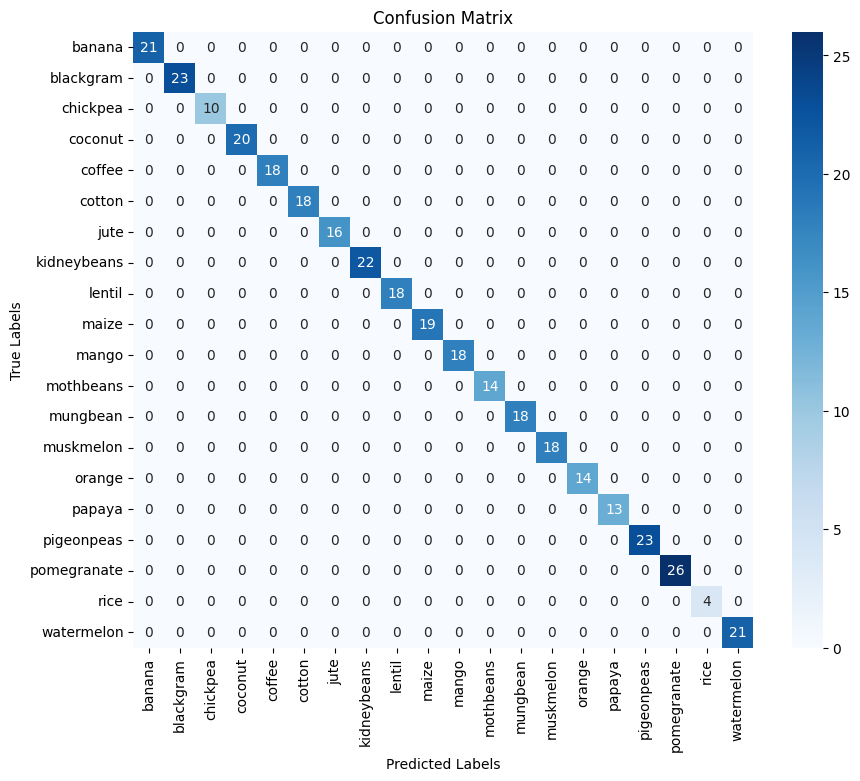

In [ ]:
# prompt: i want to check the accuracy with grapgh

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ... (Your existing code) ...

def evaluate_and_plot(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Generate classification report
    print(classification_report(all_labels, all_predictions))

    # Generate and plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy

# Train and evaluate, then get accuracy
accuracy = evaluate_and_plot(model, test_loader)


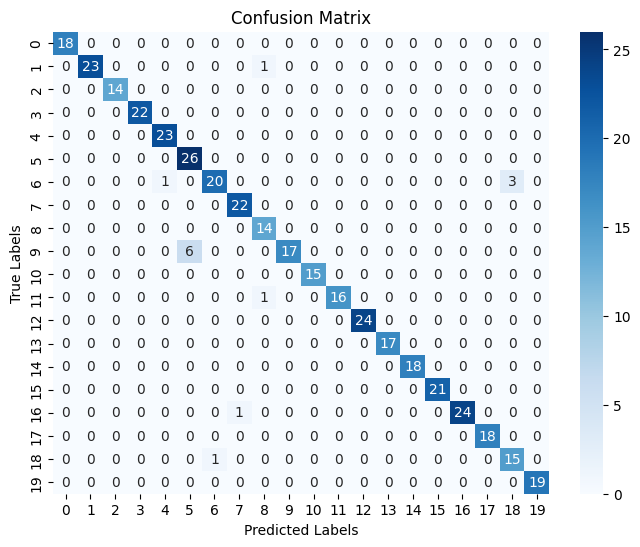

Multi-class classification detected. TP, TN, FP, FN are not directly applicable.


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_and_plot(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Extract TP, TN, FP, FN
    if cm.shape == (2, 2):  # Binary classification
        tn, fp, fn, tp = cm.ravel()
        print(f"True Positives (TP): {tp}")
        print(f"True Negatives (TN): {tn}")
        print(f"False Positives (FP): {fp}")
        print(f"False Negatives (FN): {fn}")
    else:
        print("Multi-class classification detected. TP, TN, FP, FN are not directly applicable.")

    return cm

# Evaluate model and get confusion matrix
confusion_matrix_result = evaluate_and_plot(model, test_loader)


Test Accuracy: 96.50%
F1 Score: 0.96
Precision: 0.97


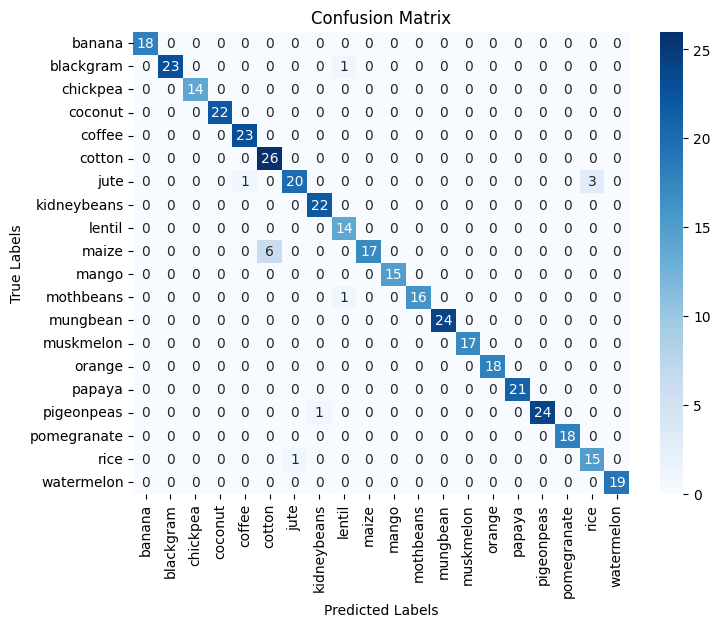


Class-wise TP, TN, FP, FN:
Class: banana
  True Positives (TP): 18
  True Negatives (TN): 382
  False Positives (FP): 0
  False Negatives (FN): 0
----------------------------------------
Class: blackgram
  True Positives (TP): 23
  True Negatives (TN): 376
  False Positives (FP): 0
  False Negatives (FN): 1
----------------------------------------
Class: chickpea
  True Positives (TP): 14
  True Negatives (TN): 386
  False Positives (FP): 0
  False Negatives (FN): 0
----------------------------------------
Class: coconut
  True Positives (TP): 22
  True Negatives (TN): 378
  False Positives (FP): 0
  False Negatives (FN): 0
----------------------------------------
Class: coffee
  True Positives (TP): 23
  True Negatives (TN): 376
  False Positives (FP): 1
  False Negatives (FN): 0
----------------------------------------
Class: cotton
  True Positives (TP): 26
  True Negatives (TN): 368
  False Positives (FP): 6
  False Negatives (FN): 0
----------------------------------------
Class:

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_and_plot(model, test_loader, label_encoder):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Accuracy, F1 Score, Precision
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')

    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")

    # Plot confusion matrix with label names
    class_names = label_encoder.classes_  # Get class names from LabelEncoder
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute TP, TN, FP, FN for each class
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    print("\nClass-wise TP, TN, FP, FN:")
    for idx, label in enumerate(class_names):
        print(f"Class: {label}")
        print(f"  True Positives (TP): {TP[idx]}")
        print(f"  True Negatives (TN): {TN[idx]}")
        print(f"  False Positives (FP): {FP[idx]}")
        print(f"  False Negatives (FN): {FN[idx]}")
        print("-" * 40)

    return cm, accuracy, f1, precision

# Evaluate model
cm, accuracy, f1, precision = evaluate_and_plot(model, test_loader, label_encoder)
